0001TP_008460.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


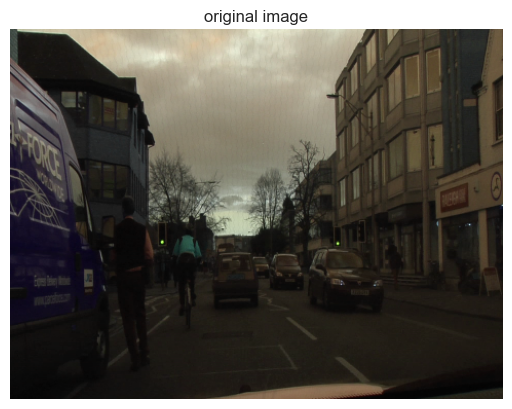

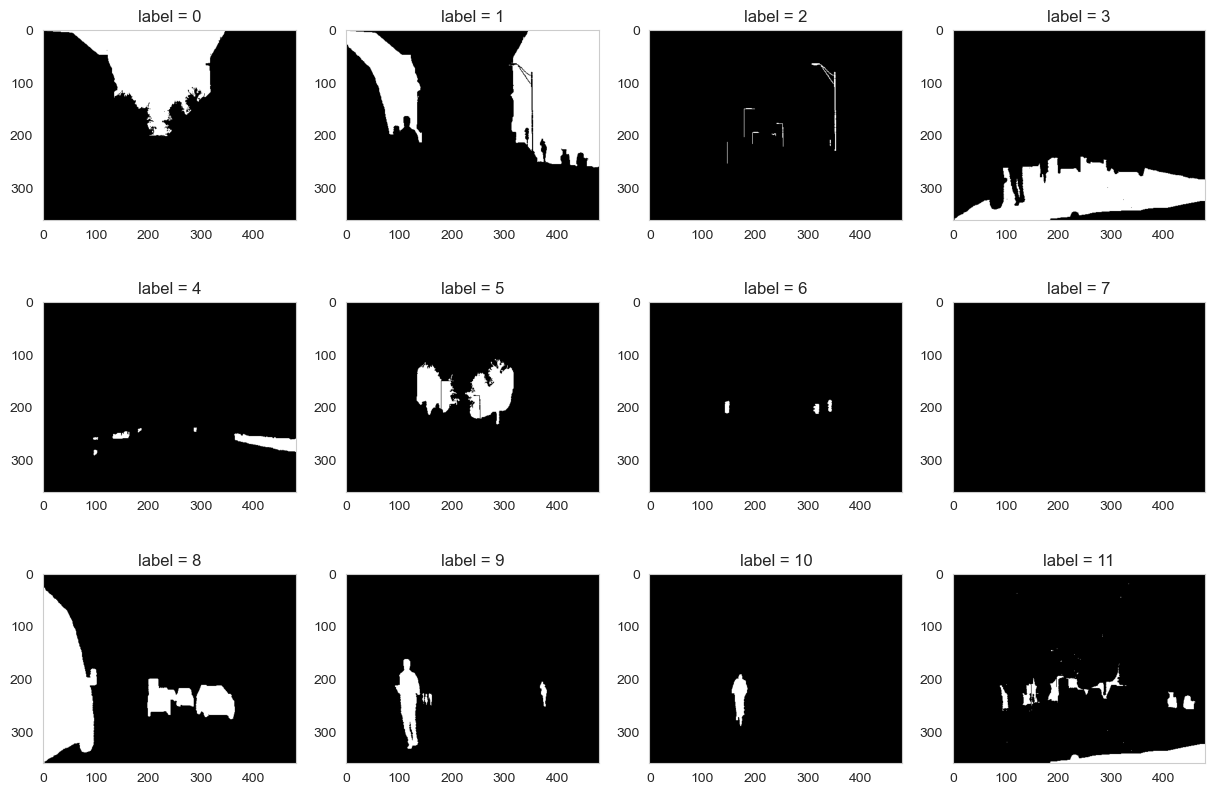

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

"""
os: file path management
seaborn, matplotlib.pyplot :plotting
"""

# set seaborn style
sns.set_style("whitegrid", {'axes.grid' : False})

# define data path 
dir_seg = "./data/Zdata/ann_dir/train"   # annotations_prepped_train
dir_img = "./data/Zdata/img_dir/train"  # images_prepped_train

ldseg = np.array(os.listdir(dir_seg))

## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
## Read first image from annotations_prepped_train and images_prepped_train with path "dir_seg +"/"+ fnm"

# Load annotations for the first training image
seg = cv2.imread(dir_seg  +"/"+ fnm)

# Load the first origin training image
img_is = cv2.imread(dir_img  +"/"+ fnm)

print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)

n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))



# Plot original image from images_prepped_train image:

plt.imshow(img_is)
plt.axis('off')
plt.title('original image')
plt.show()


# Plot all class from annotations_prepped_train image:
fig = plt.figure(figsize=(15,10))
for k in range(mi, ma+1):
    ax = fig.add_subplot(3, int(n_classes / 3), k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


"""
e.g.
seg:
 0 1 2 0
 1 2 2 1

 k = 0 (seg == k)
    T F F T
    F F F F

 *1.0 
    1.0 0 0 1.0
      0 0 0   0
"""
plt.show()

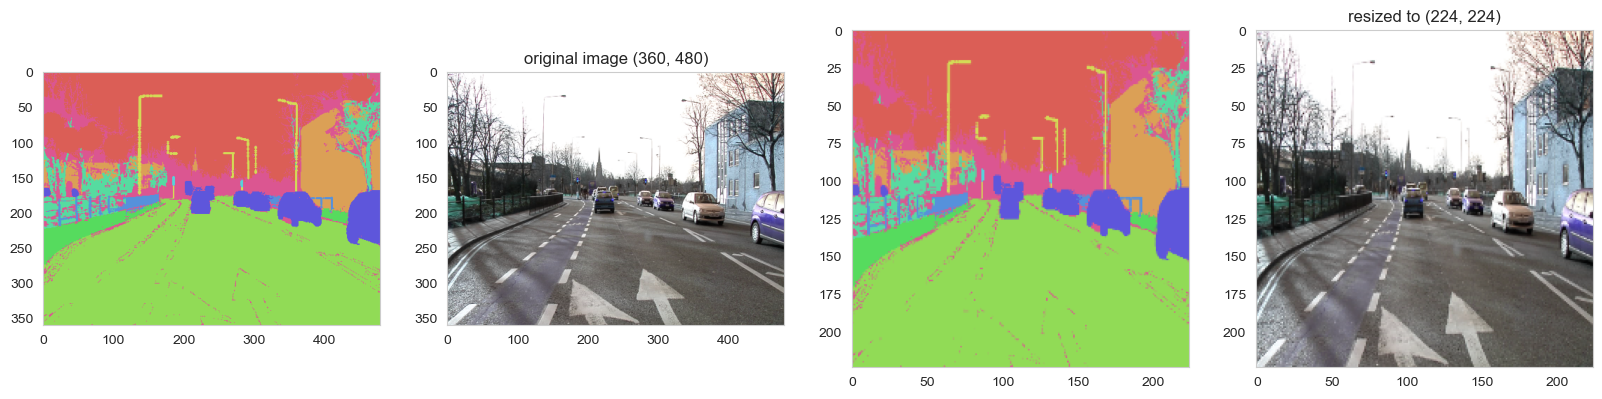

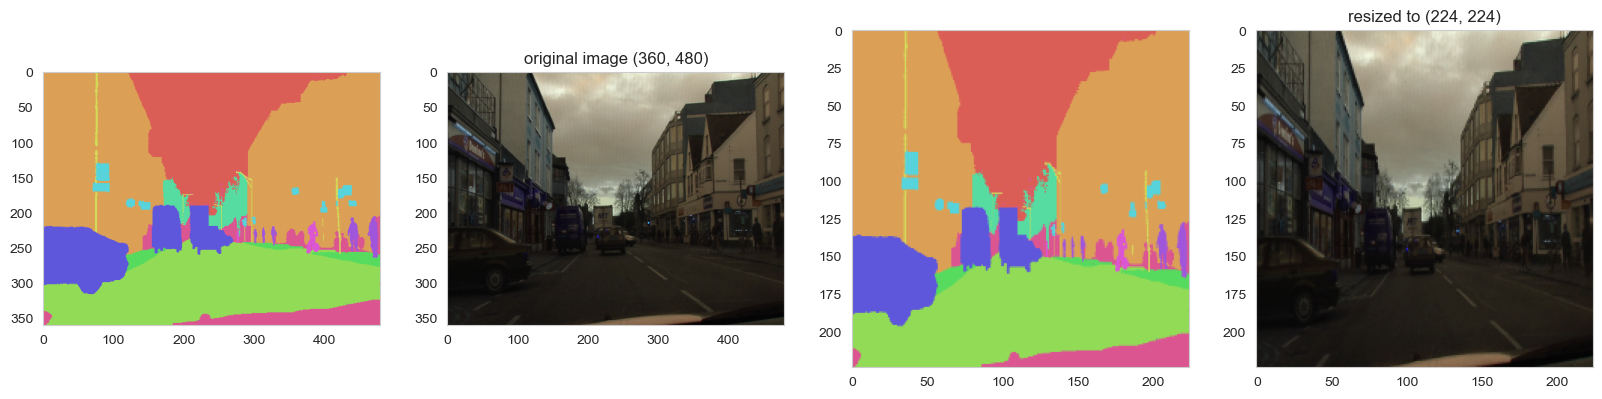

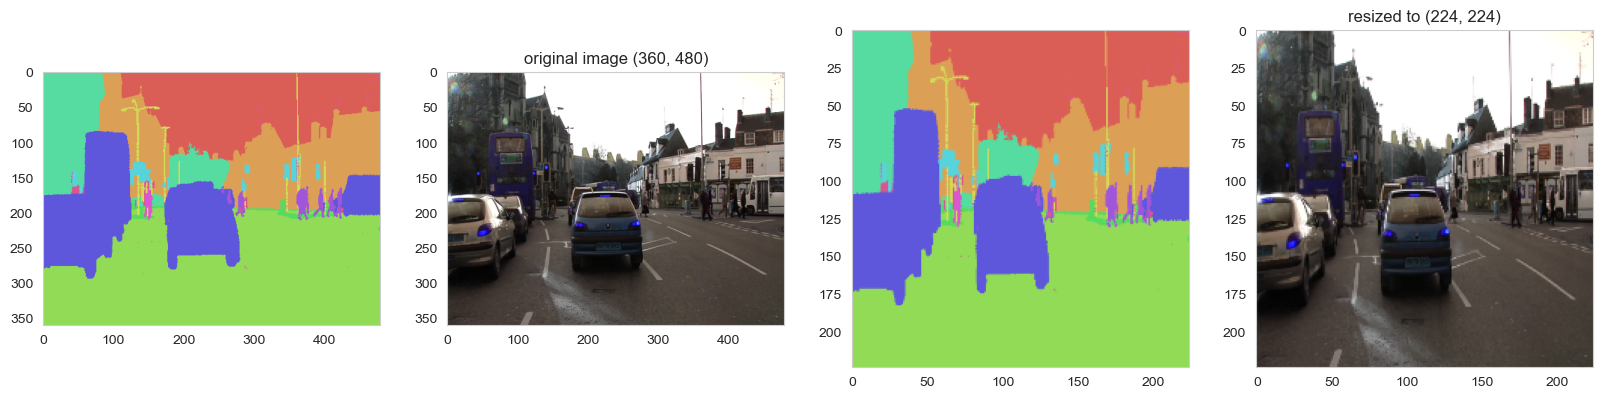

In [2]:
import random

def give_color_to_seg_img(seg,n_classes):
    '''
    seg : size is (input_width,input_height,3) -> (w, h, (x, x, x))
    assign color to each class 
        You can use sns color palette to assign color pattern
        colors = sns.color_palette("hls", n_classes)
    '''

    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
        
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    
    #colors is a 2-d array
    colors = sns.color_palette("hls", n_classes)
    
    
    for c in range(n_classes):
        segc = (seg == c)
        #segc is a bool array 
        
        
        #add to red channel[:,:,0]
        seg_img[:,:,0] += (segc*( colors[c][0] ))    
        
        #add to green channel[:,:,1]
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        
        #add to blue channel[:,:,2]
        seg_img[:,:,2] += (segc*( colors[c][2] ))
   

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    # randomly select on the training image
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg  +"/"+ fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img  +"/"+ fnm + ".png")
    # assign color to its annotations_prepped_train image
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [3]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# 定义 Dataset 类
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, img_transform=None, seg_transform=None):
        """
        初始化数据集
        Args:
            image_dir (str): 图像文件夹路径
            annotation_dir (str): 标签文件夹路径
            img_transform (callable): 图像的预处理变换
            seg_transform (callable): 标签的预处理变换
        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_transform = img_transform
        self.seg_transform = seg_transform
        self.images = sorted(os.listdir(image_dir))
        self.segmentations = sorted(os.listdir(annotation_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 加载图像和标签
        img_path = os.path.join(self.image_dir, self.images[idx])
        seg_path = os.path.join(self.annotation_dir, self.segmentations[idx])
        
        img = Image.open(img_path).convert("RGB")  # 确保是 RGB 图像
        seg = Image.open(seg_path).convert("L")    # 标签为灰度图
        
        # 应用预处理
        if self.img_transform:
            img = self.img_transform(img)
        if self.seg_transform:
            seg = self.seg_transform(seg)
        
        return img, seg


In [4]:
# 图像预处理
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.ToTensor(),          # 转换为 [C, H, W]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 标签预处理
seg_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.ToTensor(),          # 转换为 [1, H, W]
    transforms.Lambda(lambda x: x.squeeze(0).long())  # 转换为 [H, W]，并确保标签是整数
])


In [5]:
# 定义数据集路径
image_dir = "./data/Zdata/img_dir/train"
annotation_dir = "./data/Zdata/ann_dir/train"

image_dir1 = "./data/Zdata/img_dir/val"
annotation_dir1 = "./data/Zdata/ann_dir/val"

# 创建数据集实例
train_dataset = SegmentationDataset(image_dir, annotation_dir, img_transform, seg_transform)

test_dataset = SegmentationDataset(image_dir1, annotation_dir1, img_transform, seg_transform)

# 创建 DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 检查批量数据
for batch_idx, (images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print("Image batch shape:", images.shape)  # (Batch, 3, 224, 224)
    print("Mask batch shape:", masks.shape)    # (Batch, 224, 224)
    break

for batch_idx, (images, masks) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}")
    print("Image batch shape:", images.shape)  # (Batch, 3, 224, 224)
    print("Mask batch shape:", masks.shape)    # (Batch, 224, 224)
    break


Batch 1
Image batch shape: torch.Size([64, 3, 224, 224])
Mask batch shape: torch.Size([64, 224, 224])
Batch 1
Image batch shape: torch.Size([64, 3, 224, 224])
Mask batch shape: torch.Size([64, 224, 224])


In [6]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50


model = deeplabv3_resnet50(pretrained=False, num_classes=12)


print(model)


/opt/anaconda3/envs/ese5460/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ese5460/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [7]:
# 创建示例输入 (Batch=2, Channels=3, Width=224, Height=224)
inputs = torch.randn(2, 3, 224, 224)

# 获取模型输出
outputs = model(inputs)

# 输出形状
print("Output shape:", outputs["out"].shape)

Output shape: torch.Size([2, 12, 224, 224])


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models.segmentation import deeplabv3_resnet50

# 初始化模型
model = deeplabv3_resnet50(pretrained=False, num_classes=12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1E-2, momentum=0.9, weight_decay=5**(-4), nesterov=True)

# 假设 train_loader 和 test_loader 已经定义
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs['out'], targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录损失和准确率
        train_loss += loss.item()
        _, predicted = outputs['out'].max(1)
        correct += (predicted == targets).sum().item()
        total += targets.numel()  # 所有像素的总数

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

# 验证阶段
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs['out'], targets)

        test_loss += loss.item()
        _, predicted = outputs['out'].max(1)
        correct += (predicted == targets).sum().item()
        total += targets.numel()  # 验证时所有像素的总数

    test_accuracy = 100. * correct / total
    print(f"Validation Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Epoch 1/2, Loss: 7.5199, Accuracy: 3483873.30%
Epoch 2/2, Loss: 0.0715, Accuracy: 5017600.00%
Validation Loss: 1.5340, Accuracy: 5017600.00%
